In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/16-Projects/zuel/data/2001_all_materials.csv')
df = df.head(20)

In [3]:
df

,matnr,zzprncode,zzibrnd,mtart,matkl,TherapeuticClass,PrincipalName,mstae,mstde,mstav,...,idnlf,prat1,prat2,prat3,prat4,prat5,prat6,prat7,prat8,prat9
0,21047156,101276.0,DERMAVEEN SOAP FREE,ZF01,ZCS,All other non-therapeutic products,INOVA PHARMACEUTICALS (S) PTE,LR,20250101,BS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23046633,101234.0,KENHANCER PLASTER,ZF03,ZMC,Topical antirheumatics,SUN PHARMACEUTICAL SDN BHD,LR,20250101,LR,...,23046633-CCCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21210803,101223.0,TECNIS ONE ZCB 06.5D,ZF01,ZMD,Cataract and anticataractogenic preps.,ABBOTT MEDICAL OPTICS,LR,99910101,LR,...,ZCB0000065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23064902,101369.0,REDOXON KIDS DA CHEW,ZF03,ZCH,Vitamin C combinations,BAYER CO (MALAYSIA) SDN BHD,LR,20250101,LR,...,80450592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21037570,101223.0,TECNIS ONE ZCB 21.0D,ZF01,ZMD,Cataract and anticataractogenic preps.,ABBOTT MEDICAL OPTICS,LR,20250101,LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,23344235,102575.0,SynMesh Cutter,ZF03,ZPE,Promotional items,STRYKER CORPORATION (M) SDN BHD,LR,99901231,LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,23063927,101365.0,FLUOROCELL WDF,ZF03,ZMD,All other diagnostic tests,SYSMEX (M) SDN BHD (PCL a/c),LR,20250101,LR,...,CV377552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,23073116,101286.0,ADALAT LA,ZF03,ZPE,"Calcium antagonists, plain",BAYER CO (M) SDN BHD (PCL a/c),LR,20250101,LR,...,3594436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,23046886,101236.0,ZOVIRAX OPTH,ZF03,ZPE,Ophthalmological antiviral agents,GLAXOSMITHKLINE PHARMACEUTICAL_,LR,20250101,LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,23071153,101242.0,OXY OIL CONTROL TONE,ZF03,ZCS,"Emollients, protectives",ROHTO-MENTHOLATUM (M) SDN BHD,LR,20250101,LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['zzibrnd'] = df['zzibrnd'].astype(str)
df['TherapeuticClass'] = df['TherapeuticClass'].astype(str)
df['PrincipalName'] = df['PrincipalName'].astype(str)
df['Description'] = df['Description'].astype(str)

In [5]:
# remove special characters (& \n) from category/sub category/type
def splitcategory(x):
    if isinstance(x, list):
        return x
    else:
        if isinstance(x, str):
            res = re.split('& |, |\*|\n', x)
            return res
        else:
            return ''

# function to change characters to lower case
def cleaner(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

# change text to lower case
def changeCase(x):
    return str.lower(x)

# merge all text columns
def couple(x):
    return x['zzibrnd'] + ' ' + ' '.join(x['TherapeuticClass_new']) + ' '.join( x['PrincipalName_new']) + ' ' + x['Description'] 

In [6]:
# remove special characters
df['zzibrnd_new'] = df['zzibrnd'].apply(splitcategory)
df['TherapeuticClass_new'] = df['TherapeuticClass'].apply(splitcategory)
df['PrincipalName_new'] = df['PrincipalName'].apply(splitcategory)


# mix all text columns
df['soup'] = df.apply(couple, axis=1)
df['soup'] = df['soup'].apply(changeCase)

In [7]:
df['soup'][0]

'dermaveen soap free all other non-therapeutic productsinova pharmaceuticals (s) pte dermaveen soap freewash500ml'

In [8]:
def preprocess_text(question):
    question = question.replace("S08_", "")
    question = question.replace("NOTTTT  FOUND", "")
    question = re.sub("([\(\[]).*?([\)\]])", "", question) # remove text between brackets
    question = re.sub("[^\w\s]", "", question) # remove punctuations
    re.sub("\s+", " ", question) # remove multiple white spaces
    re.sub("[\t\n]", "", question) # remove tabs and newline characters
    re.sub("[_]", "", question) # remove tabs and newline characters
    question = question.lower().strip()
    return question

In [9]:
df['soup'] = df['soup'].apply(preprocess_text)

In [10]:
text = df['soup']
text

0     dermaveen soap free all other nontherapeutic p...
1     kenhancer plaster topical antirheumaticssun ph...
2     tecnis one zcb 065d cataract and anticataracto...
3     redoxon kids da chew vitamin c combinationsbay...
4     tecnis one zcb 210d cataract and anticataracto...
5     synmesh cutter promotional itemsstryker corpor...
6     fluorocell wdf all other diagnostic testssysme...
7     adalat la calcium antagonists plainbayer co  s...
8     zovirax opth ophthalmological antiviral agents...
9     oxy oil control tone emollients protectivesroh...
10    nimotop calcium antagonists w cerebral activit...
11    johnsons lotion soa other dermatological prepa...
12    magnesium amino acid multivitamins with minera...
13    lamisil systemic agents for fungal infectionsn...
14    wellbutrin sr antidepressants all othersglaxos...
15    zaditen syrup systemic antihistaminesnovartis ...
16    zocor statins merck sharp  dohme  zocortabs10m...
17    tubinette 20m roll all other wound healing

In [17]:
s = ''
for t in text:
    s += t + ' '
s

'dermaveen soap free all other nontherapeutic productsinova pharmaceuticals  pte dermaveen soap freewash500ml kenhancer plaster topical antirheumaticssun pharmaceutical sdn bhd kenhancer plaster20s tecnis one zcb 065d cataract and anticataractogenic prepsabbott medical optics tecnis one zcb 065d redoxon kids da chew vitamin c combinationsbayer co  sdn bhd redoxon kids da chewabletab60s tecnis one zcb 210d cataract and anticataractogenic prepsabbott medical optics tecnis one zcb 210d synmesh cutter promotional itemsstryker corporation  sdn bhd synmesh cutter v3 fluorocell wdf all other diagnostic testssysmex  sdn bhd  fluorocell wdfst2x42ml adalat la calcium antagonists plainbayer co  sdn bhd  adalat latabs30mg30s zovirax opth ophthalmological antiviral agentsglaxosmithkline pharmaceutical_ zovirax opthoint45gm oxy oil control tone emollients protectivesrohtomentholatum  sdn bhd oxy oil control toner150ml nimotop calcium antagonists w cerebral activitybayer co  sdn bhd  nimotoptabs30mg3

In [12]:
text.to_csv('text.csv')

In [11]:
def preprocess_length(question):
    return len(question)

In [12]:
df['soup_length'] = df['soup'].apply(preprocess_length)

C:\Users\DELL\.conda\envs\projects\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='soup_length', ylabel='Density'>

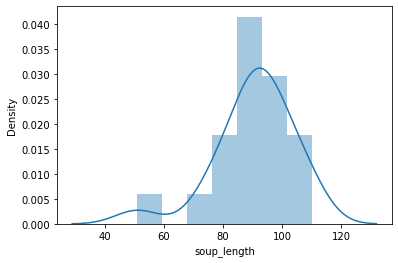

In [13]:
sns.distplot(df['soup_length'])

In [14]:
vocab = sorted(set("".join(text)))

In [15]:
vocab

[' ',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '9',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [16]:
class QuestionsDataset(Dataset):
    def __init__(self, questions, vocab, sos_token, eos_token, batch_first=False):
        
        # initialize parameters
        self.sos_idx = 0
        self.eos_idx = 1
        self.int2char = {self.sos_idx: sos_token, self.eos_idx: eos_token} # insert start of sentence and end of sentence tokens
        self.int2char.update({idx: char for idx, char in enumerate(vocab, start=self.eos_idx+1)})
        self.char2int = {char: idx for idx, char in self.int2char.items()}
        self.n_chars = len(self.int2char)
        
        # encode and pad questions
        self.questions_encoded = pad_sequence([self.encode_question(q) for q in questions], \
                                              batch_first=batch_first)
                
    def __len__(self):
        return len(self.questions_encoded)
    
    def __getitem__(self, idx):
        return self.questions_encoded[idx]
        
    def encode_question(self, question):
        '''
        encode question as char indices and perform one-hot encoding
        '''
        question_encoded = [self.sos_idx] # append sos
        for char in question:
            question_encoded.append(self.char2int[char])
        question_encoded.append(self.eos_idx) # append eos
        return F.one_hot(torch.tensor(question_encoded, dtype=torch.long), self.n_chars).float()

In [17]:
vocab = sorted(set("".join(text)))
sos_token = '['
eos_token = ']'
BATCH_FIRST=True
BATCH_SIZE=2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
val_percent = 0.2
n_val = int(val_percent * len(text))
n_train = len(text) - n_val
print(f"train: {n_train}, val: {n_val}")

train: 16, val: 4


In [19]:
questions_train =text[:n_train]
questions_val = text[n_train:]

In [20]:
questions_val

16    zocor statins merck sharp  dohme  zocortabs10m...
17    tubinette 20m roll all other wound healing age...
18    ux ii search sed st all other diagnostic tests...
19    uriage depiderm soin emollients protectiveslab...
Name: soup, dtype: object

In [21]:
train_dataset = QuestionsDataset(questions_train, vocab, sos_token, eos_token, batch_first=BATCH_FIRST)
val_dataset = QuestionsDataset(questions_val, vocab, sos_token, eos_token, batch_first=BATCH_FIRST)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
assert train_dataset.n_chars == val_dataset.n_chars

In [23]:
val_dataset.n_chars

38

In [24]:
class charRNN(nn.Module):
    
    def __init__(self, VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS=2, P_DROPOUT=0.5, batch_first=False):
        super().__init__()
        self.HIDDEN_SIZE = HIDDEN_SIZE
        self.N_LAYERS = N_LAYERS
        self.lstm = nn.LSTM(VOCAB_SIZE, HIDDEN_SIZE, batch_first=batch_first, 
                            dropout=P_DROPOUT, num_layers=N_LAYERS)
        self.dropout = nn.Dropout(P_DROPOUT)
        self.fc = nn.Linear(HIDDEN_SIZE, VOCAB_SIZE)
        
    def forward(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden)
        
        # flatten the lstm output
        lstm_out = torch.flatten(lstm_out, start_dim=0, end_dim=1)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, BATCH_SIZE, device):
        hidden = (torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).to(device),
                  torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).to(device))
        return hidden

In [25]:
VOCAB_SIZE=train_dataset.n_chars
HIDDEN_SIZE=512
N_LAYERS=3
P_DROPOUT = 0.4

In [26]:
model = charRNN(VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS, P_DROPOUT, BATCH_FIRST)

In [27]:
model.to(device=device)

charRNN(
  (lstm): LSTM(38, 512, num_layers=3, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=38, bias=True)
)

In [28]:
save_epoch = 10 

In [29]:
import os
from tqdm import tqdm

In [30]:
n_epochs = 20
optimizer = optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()
clip = 5

In [35]:
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(1, n_epochs+1)):  
    
    # training
    # -------------

    n_batches_train = 0
    cummulative_loss_train = 0 
    
    model.train()
    
    # initialize hidden state
    hidden = model.init_hidden(BATCH_SIZE, device)
    
    for data_batch in train_dataloader:
        
        # detach hidden state
        hidden = tuple([h.detach() for h in hidden])
        
        if data_batch.shape[0] != BATCH_SIZE:
            continue
        
        # get data
        labels, targets = data_batch[:, :-1, :].to(device), data_batch[:, 1:, :].to(device)
        # get predictions
        preds, hidden = model(labels, hidden)
        # compute loss
        target_idx = torch.argmax(targets, dim=2).long()
        target_flatten = torch.flatten(target_idx, start_dim=0, end_dim=1)
        train_loss = loss(preds, target_flatten)

        # backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        
        # clip the gradient before updating the weights
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        n_batches_train += 1
        cummulative_loss_train += train_loss.item()
        
    loss_per_epoch_train = cummulative_loss_train / n_batches_train
    train_loss_list.append(loss_per_epoch_train)
    
    # validation
    # ---------------
    
    n_batches_val = 0
    cummulative_loss_val = 0 
    
    model.eval()
    hidden = model.init_hidden(BATCH_SIZE, device)
    
    for data_batch in val_dataloader:
        
        if data_batch.shape[0] != BATCH_SIZE:
            continue

        # get data
        labels, targets = data_batch[:, :-1, :].to(device), data_batch[:, 1:, :].to(device)
        # get predictions
        with torch.no_grad():
            preds, hidden = model(labels, hidden)
            # compute loss
            target_idx = torch.argmax(targets, dim=2).long()
            target_flatten = torch.flatten(target_idx, start_dim=0, end_dim=1)
            val_loss = loss(preds, target_flatten)
            
        n_batches_val += 1
        cummulative_loss_val += val_loss.item()
    
    loss_per_epoch_val = cummulative_loss_val / n_batches_val
    val_loss_list.append(loss_per_epoch_val)
    
    # save model every 10 epochs
    if epoch % save_epoch == 0:
        model_name = f"charRNN_questions_epoch_{epoch}.pt"
        save_path = os.path.join("D:\\2023\\rkumar-bengaluru\\data-science\\17-Deep-Learning\\17-RNN", model_name)
        torch.save(model.state_dict(), save_path)

100%|██████████| 20/20 [04:46<00:00, 14.35s/it]


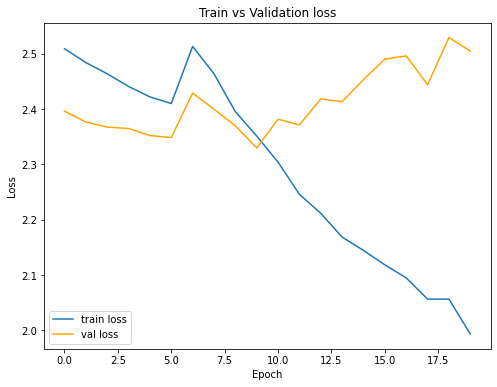

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_loss_list, label="train loss")
axes.plot(list(range(n_epochs)), val_loss_list, color='orange', label="val loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.set_title("Train vs Validation loss")

plt.legend()

In [37]:
class GenerateText:
    def __init__(self, model, k, int2char, char2int, device):
        self.int2char = int2char
        self.char2int = char2int
        self.n_chars = len(int2char)
        self.model = model
        self.device = device
        self.k = k
        self.sos_token = self.int2char[0]
        self.eos_token = self.int2char[1]
        
    def predict_next_char(self, hidden, input_char):
        
        # encode char
        char_one_hot = self.encode_char(input_char)

        # get the predictions
        with torch.no_grad():
            out, hidden = self.model(char_one_hot, hidden)
            
            # convert the output to a character probability distribution
            p = F.softmax(out, dim=1)

            # move to cpu as numpy doesn't support gpu
            p = p.cpu()

            # get top k characters from the distribution
            values, indices = p.topk(self.k)

        indices = indices.squeeze().numpy()
        values = values.squeeze().numpy()

        # sample any char from the top k chars using the output softmax distribution
        char_pred = np.random.choice(indices, size=1, p=values/values.sum())

        return self.int2char[char_pred[0]], hidden
    
    def generate_text(self, prime, max_chars=20):
        
        prime = self.sos_token + prime

        all_chars = [char for char in prime]
        print(all_chars)
        hidden = model.init_hidden(1, self.device)

        # build up the hidden state using the initial prime
        for char in prime:
            char_pred, hidden = self.predict_next_char(hidden, char)

        all_chars.append(char_pred)
        print(all_chars)

        # generate n chars
        c = len(all_chars)
        print(c)
        while char_pred != self.eos_token:
            if c == max_chars:
                break
            char_pred, hidden = self.predict_next_char(hidden, all_chars[-1])
            all_chars.append(char_pred)
            c += 1

        return "".join(all_chars)
        
    def encode_char(self, char):
        char_int = self.char2int[char]
        char_one_hot = F.one_hot(torch.tensor(char_int), self.n_chars).float()
        return char_one_hot.unsqueeze(0).unsqueeze(0).to(self.device)

In [50]:
k = 4
text_generator = GenerateText(model, k, train_dataset.int2char, train_dataset.char2int, device)
response = text_generator.generate_text('john', max_chars=100)
response

['[', 'j', 'o', 'h', 'n']
['[', 'j', 'o', 'h', 'n', 's']
6


'[johnsons sdnesil hol bhd mmormal  al  hd  araricoc soltbhd   lem ar antoc  srettholetarilec  drerts'

In [46]:
text

0     dermaveen soap free all other nontherapeutic p...
1     kenhancer plaster topical antirheumaticssun ph...
2     tecnis one zcb 065d cataract and anticataracto...
3     redoxon kids da chew vitamin c combinationsbay...
4     tecnis one zcb 210d cataract and anticataracto...
5     synmesh cutter promotional itemsstryker corpor...
6     fluorocell wdf all other diagnostic testssysme...
7     adalat la calcium antagonists plainbayer co  s...
8     zovirax opth ophthalmological antiviral agents...
9     oxy oil control tone emollients protectivesroh...
10    nimotop calcium antagonists w cerebral activit...
11    johnsons lotion soa other dermatological prepa...
12    magnesium amino acid multivitamins with minera...
13    lamisil systemic agents for fungal infectionsn...
14    wellbutrin sr antidepressants all othersglaxos...
15    zaditen syrup systemic antihistaminesnovartis ...
16    zocor statins merck sharp  dohme  zocortabs10m...
17    tubinette 20m roll all other wound healing